In [9]:
import math
import os
from collections import defaultdict
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

from nltk import ngrams

In [10]:
dir_path = '/home/anton/Университет/МЛ/lab4/messages/'


def generate_ngrams(text, n):
    tokens = [token for token in text.split(' ') if token != '']
    return list(ngrams(tokens, n))


def read_parts(n):
    X = []
    Y = []
    for i in range(10):
        cur_X = []
        cur_Y = []
        cur_dir = dir_path + 'part' + str(i + 1)
        for filename in os.listdir(cur_dir):
            file = open(cur_dir + '/' + filename, 'r')
            subject = list(map(int, file.readline().split()[1:]))
            file.readline()
            text = list(map(int, file.readline().split()))
            all = subject
            all.extend(text)
            ngram = generate_ngrams(' '.join(str(x) for x in all), n)
            cur_X.append(ngram)
            if 'legit' in filename:
                cur_Y.append(0)
            else:
                cur_Y.append(1)
        X.append(cur_X)
        Y.append(cur_Y)
    return X, Y

In [11]:
def class_probability(X, classes_count, class_type):
    return classes_count.get(class_type) / len(X)


def init_Bayes(X, Y):
    words = set()
    classes_count = defaultdict(lambda: 0)
    frequency = defaultdict(lambda: 0)

    for i in range(len(X)):
        message = X[i]
        message_type = Y[i]

        classes_count[message_type] += 1
        for word in message:
            words.add(word)
            frequency[message_type, word] += 1

    return classes_count, frequency


def predict(X, test, lambdas, alpha, classes_count, frequency):
    Q = 2
    probability_legit = math.log(lambdas[0] * class_probability(X, classes_count, 0))
    probability_spam = math.log(lambdas[1] * class_probability(X, classes_count, 1))

    for word in test:
        cur_probability_legit = math.log((frequency.get((0, word), 0) + alpha) / (classes_count[0] + Q * alpha))
        cur_probability_spam = math.log((frequency.get((1, word), 0) + alpha) / (classes_count[1] + Q * alpha))

        probability_legit += cur_probability_legit
        probability_spam += cur_probability_spam

    if probability_legit > probability_spam:
        return 0
    else:
        return 1

In [12]:
def train_tests_x_y(X, Y):
    x_y = []
    for i in range(len(X)):
        X_test, Y_test = X[i], Y[i]

        X_copy, Y_copy = X.copy(), Y.copy()
        X_copy.pop(i)
        Y_copy.pop(i)

        X_train = [item for sublist in X_copy for item in sublist]
        Y_train = [item for sublist in Y_copy for item in sublist]

        x_y.append((X_train, Y_train, X_test, Y_test))
    return x_y

In [13]:
def cross_validation(X, Y, x_y, alpha, legit_lambda):
    accuracy = []
    legit_wrong_counter = 0
    for X_train, Y_train, X_test, Y_test in x_y:
        Y_predicts = []
        for i in range(len(X_test)):
            cur_elem = X_test[i]
            classes_count, frequency = init_Bayes(X_train, Y_train)
            Y_predict = predict(X, cur_elem, [legit_lambda, 1], alpha, classes_count, frequency)
            Y_predicts.append(Y_predict)
            if Y_test[i] == 0 and Y_predict == 1:
                legit_wrong_counter += 1
        accuracy.append(accuracy_score(Y_test, Y_predicts))
    return np.average(np.array(accuracy)), legit_wrong_counter

In [23]:
alphas = [10 ** i for i in range(-10, -3)]


def alpha_optimization(X, Y, x_y):
    alpha_best = -1
    accuracy_best = -1

    for alpha in alphas:
        accuracy, _ = cross_validation(X, Y, x_y, alpha, 1)
        if accuracy > accuracy_best:
            accuracy_best = accuracy
            alpha_best = alpha
        print('----------')
        print(f'Alpha is {alpha}')
        print(f'Accuracy is {accuracy}')
    return accuracy_best, alpha_best

In [28]:
def lambda_optimization(X, Y, x_y, alpha, beg, end):
    legit_lambdas = [10 ** i for i in range(beg, end)]
    legit_lambda_best = 0
    accuracy_best = -1
    for legit_lambda in legit_lambdas:
        accuracy, legit_wrong_count = cross_validation(X, Y, x_y, alpha, legit_lambda)
        if accuracy > accuracy_best and legit_wrong_count == 0:
            accuracy_best = accuracy
            legit_lambda_best = legit_lambda
        print('----------')
        print('Legit lambda is 1e{}'.format(math.log10(legit_lambda)))
        print(f'Legit wrong count is {legit_wrong_count}')
        print(f'Accuracy is {accuracy}')
    return accuracy_best, legit_lambda_best

----------
Alpha is 1e-10
Accuracy is 0.9761467889908257
----------
Alpha is 1e-09
Accuracy is 0.9770642201834863
----------
Alpha is 1e-08
Accuracy is 0.9761467889908257
----------
Alpha is 1e-07
Accuracy is 0.9752293577981652
----------
Alpha is 1e-06
Accuracy is 0.9761467889908257
----------
Alpha is 1e-05
Accuracy is 0.9715596330275229
----------
Alpha is 0.0001
Accuracy is 0.9669724770642203
Accuracy best is 0.9770642201834863
Alpha best is 1e-09


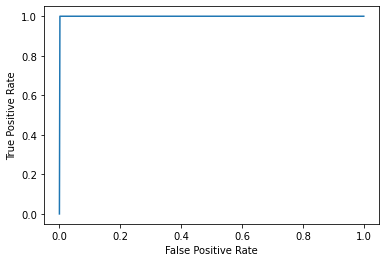

In [24]:
X, Y = read_parts(1)  # n = 1
x_y = train_tests_x_y(X, Y)
accuracy_best, alpha_best = alpha_optimization(X, Y, x_y)
print(f'Accuracy best is {accuracy_best}')
print(f'Alpha best is {alpha_best}')
X_all = [item for sublist in X for item in sublist]
Y_all = [item for sublist in Y for item in sublist]
y_pred = []

for x in X_all:
    classes_count, frequency = init_Bayes(X_all, Y_all)
    pred = predict(X_all, x, [1, 1], alpha_best, classes_count, frequency)
    y_pred.append(pred)

FPR, TPR, _ = roc_curve(Y_all, y_pred)
plt.plot(FPR, TPR)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [29]:
accuracy_lambda_best, legit_lambda_best = lambda_optimization(X, Y, x_y, alpha_best, 290, 300)
print('----------')
print(f'Accuracy lambda best is {accuracy_lambda_best}')
print(f'Legit lambda best is {legit_lambda_best}')

----------
Legit lambda is 1e290.0
Legit wrong count is 1
Accuracy is 0.7651376146788992
----------
Legit lambda is 1e291.0
Legit wrong count is 1
Accuracy is 0.7651376146788992
----------
Legit lambda is 1e292.0
Legit wrong count is 0
Accuracy is 0.7651376146788992
----------
Legit lambda is 1e293.0
Legit wrong count is 0
Accuracy is 0.7651376146788992
----------
Legit lambda is 1e294.0
Legit wrong count is 0
Accuracy is 0.7651376146788992
----------
Legit lambda is 1e295.0
Legit wrong count is 0
Accuracy is 0.7651376146788992
----------
Legit lambda is 1e296.0
Legit wrong count is 0
Accuracy is 0.7642201834862385
----------
Legit lambda is 1e297.0
Legit wrong count is 0
Accuracy is 0.7642201834862385
----------
Legit lambda is 1e298.0
Legit wrong count is 0
Accuracy is 0.763302752293578
----------
Legit lambda is 1e299.0
Legit wrong count is 0
Accuracy is 0.763302752293578
----------
Accuracy lambda best is 0.7651376146788992
Legit lambda best is 1000000000000000000000000000000000000

Лучшая лямбда - 10e292

In [30]:
legit_lambdas = [10 ** i for i in range(1, 292, 40)]
accuracys = []
for legit_lambda in legit_lambdas:
    y_predicts = []
    for i in range(len(X_all)):
        elem = X_all[i]
        classes_count, frequency = init_Bayes(X_all, Y_all)
        pred = predict(X_all, elem, [legit_lambda, 1], alpha_best, classes_count, frequency)
        y_predicts.append(pred)
    accuracy = accuracy_score(Y_all, y_predicts)
    accuracys.append(accuracy)
    print('Current legit lambda is 1e{}'.format(math.log10(legit_lambda)))
    print(f'Current accuracy is {accuracy}')

Current legit lambda is 1e1.0
Current accuracy is 0.9990825688073395
Current legit lambda is 1e41.0
Current accuracy is 0.9908256880733946
Current legit lambda is 1e81.0
Current accuracy is 0.963302752293578
Current legit lambda is 1e121.0
Current accuracy is 0.9174311926605505
Current legit lambda is 1e161.0
Current accuracy is 0.8871559633027523
Current legit lambda is 1e201.0
Current accuracy is 0.865137614678899
Current legit lambda is 1e241.0
Current accuracy is 0.8412844036697248
Current legit lambda is 1e281.0
Current accuracy is 0.8192660550458716


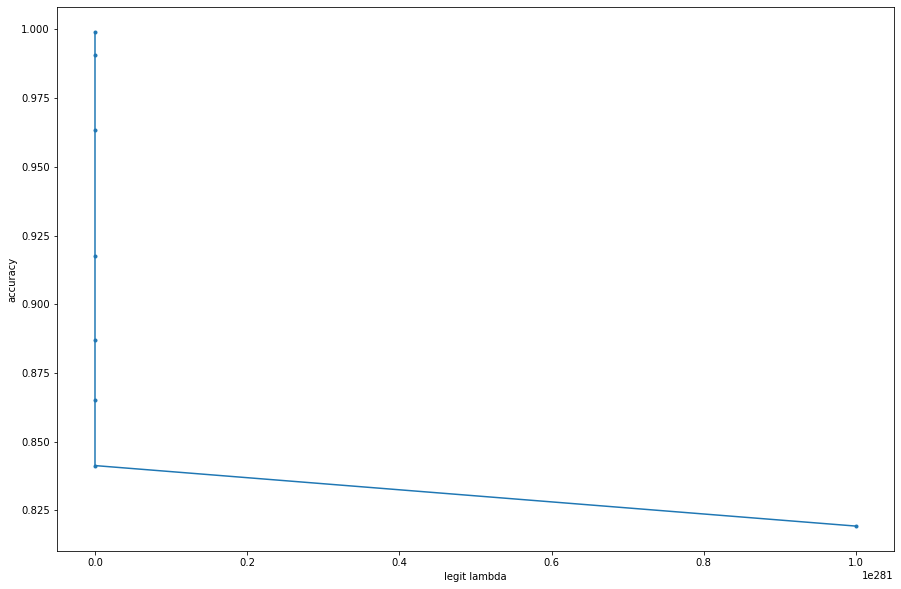

In [31]:
plt.figure(figsize=(15, 10))
plt.plot(legit_lambdas, accuracys, linestyle='-', marker='.')
plt.xlabel('legit lambda')
plt.ylabel('accuracy')
plt.show()

----------
Alpha is 1e-10
Accuracy is 0.9807339449541285
----------
Alpha is 1e-09
Accuracy is 0.9807339449541285
----------
Alpha is 1e-08
Accuracy is 0.9807339449541285
----------
Alpha is 1e-07
Accuracy is 0.9807339449541285
----------
Alpha is 1e-06
Accuracy is 0.9798165137614679
----------
Alpha is 1e-05
Accuracy is 0.9779816513761469
----------
Alpha is 0.0001
Accuracy is 0.9770642201834863
Accuracy best is 0.9807339449541285
Alpha best is 1e-10


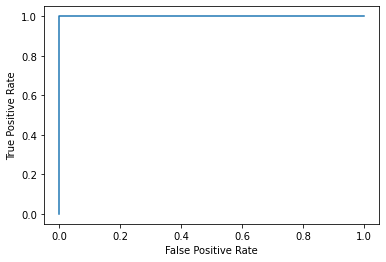

In [33]:
X, Y = read_parts(2)  # n = 2
x_y = train_tests_x_y(X, Y)
accuracy_best, alpha_best = alpha_optimization(X, Y, x_y)
print(f'Accuracy best is {accuracy_best}')
print(f'Alpha best is {alpha_best}')
X_all = [item for sublist in X for item in sublist]
Y_all = [item for sublist in Y for item in sublist]
y_pred = []

for x in X_all:
    classes_count, frequency = init_Bayes(X_all, Y_all)
    pred = predict(X_all, x, [1, 1], alpha_best, classes_count, frequency)
    y_pred.append(pred)

FPR, TPR, _ = roc_curve(Y_all, y_pred)
plt.plot(FPR, TPR)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [34]:
accuracy_lambda_best, legit_lambda_best = lambda_optimization(X, Y, x_y, alpha_best, 300, 310)
print('----------')
print(f'Accuracy lambda best is {accuracy_lambda_best}')
print(f'Legit lambda best is {legit_lambda_best}')

----------
Legit lambda is 1e300.0
Legit wrong count is 2
Accuracy is 0.9009174311926605
----------
Legit lambda is 1e301.0
Legit wrong count is 2
Accuracy is 0.9
----------
Legit lambda is 1e302.0
Legit wrong count is 2
Accuracy is 0.9
----------
Legit lambda is 1e303.0
Legit wrong count is 2
Accuracy is 0.9
----------
Legit lambda is 1e304.0
Legit wrong count is 2
Accuracy is 0.9
----------
Legit lambda is 1e305.0
Legit wrong count is 2
Accuracy is 0.9
----------
Legit lambda is 1e306.0
Legit wrong count is 2
Accuracy is 0.9
----------
Legit lambda is 1e307.0
Legit wrong count is 0
Accuracy is 0.5596330275229358
----------
Legit lambda is 1e308.0
Legit wrong count is 0
Accuracy is 0.5596330275229358


OverflowError: int too large to convert to float

Лучшая лямбда 1е307

In [35]:
legit_lambdas = [10 ** i for i in range(1, 307, 50)]
accuracys = []
for legit_lambda in legit_lambdas:
    y_predicts = []
    for i in range(len(X_all)):
        elem = X_all[i]
        classes_count, frequency = init_Bayes(X_all, Y_all)
        pred = predict(X_all, elem, [legit_lambda, 1], alpha_best, classes_count, frequency)
        y_predicts.append(pred)
    accuracy = accuracy_score(Y_all, y_predicts)
    accuracys.append(accuracy)
    print('Current legit lambda is 1e{}'.format(math.log10(legit_lambda)))
    print(f'Current accuracy is {accuracy}')

Current legit lambda is 1e1.0
Current accuracy is 1.0
Current legit lambda is 1e51.0
Current accuracy is 1.0
Current legit lambda is 1e101.0
Current accuracy is 0.9990825688073395
Current legit lambda is 1e151.0
Current accuracy is 0.9954128440366973
Current legit lambda is 1e201.0
Current accuracy is 0.9935779816513761
Current legit lambda is 1e251.0
Current accuracy is 0.9853211009174312
Current legit lambda is 1e301.0
Current accuracy is 0.9807339449541285


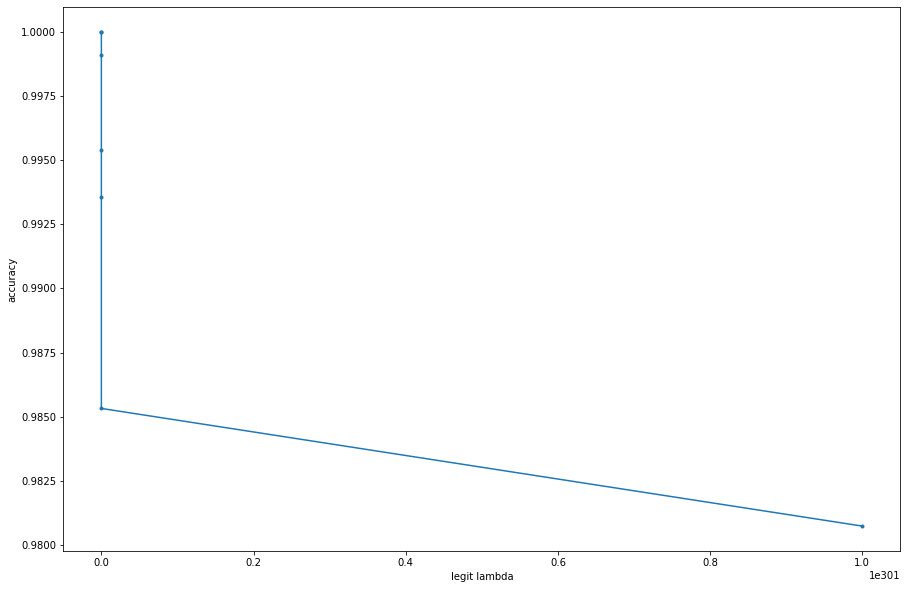

In [36]:
plt.figure(figsize=(15, 10))
plt.plot(legit_lambdas, accuracys, linestyle='-', marker='.')
plt.xlabel('legit lambda')
plt.ylabel('accuracy')
plt.show()

----------
Alpha is 1e-10
Accuracy is 0.9761467889908257
----------
Alpha is 1e-09
Accuracy is 0.9752293577981652
----------
Alpha is 1e-08
Accuracy is 0.9752293577981652
----------
Alpha is 1e-07
Accuracy is 0.9770642201834863
----------
Alpha is 1e-06
Accuracy is 0.9752293577981652
----------
Alpha is 1e-05
Accuracy is 0.9724770642201834
----------
Alpha is 0.0001
Accuracy is 0.9706422018348624
Accuracy best is 0.9770642201834863
Alpha best is 1e-07


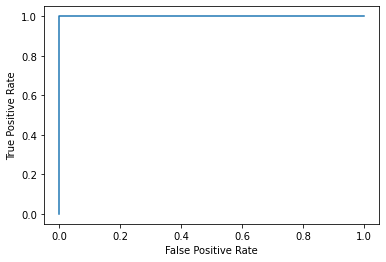

In [37]:
X, Y = read_parts(3)  # n = 3
x_y = train_tests_x_y(X, Y)
accuracy_best, alpha_best = alpha_optimization(X, Y, x_y)
print(f'Accuracy best is {accuracy_best}')
print(f'Alpha best is {alpha_best}')
X_all = [item for sublist in X for item in sublist]
Y_all = [item for sublist in Y for item in sublist]
y_pred = []

for x in X_all:
    classes_count, frequency = init_Bayes(X_all, Y_all)
    pred = predict(X_all, x, [1, 1], alpha_best, classes_count, frequency)
    y_pred.append(pred)

FPR, TPR, _ = roc_curve(Y_all, y_pred)
plt.plot(FPR, TPR)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [38]:
accuracy_lambda_best, legit_lambda_best = lambda_optimization(X, Y, x_y, alpha_best, 300, 310)
print('----------')
print(f'Accuracy lambda best is {accuracy_lambda_best}')
print(f'Legit lambda best is {legit_lambda_best}')

----------
Legit lambda is 1e300.0
Legit wrong count is 4
Accuracy is 0.8697247706422019
----------
Legit lambda is 1e301.0
Legit wrong count is 4
Accuracy is 0.8697247706422019
----------
Legit lambda is 1e302.0
Legit wrong count is 4
Accuracy is 0.8697247706422019
----------
Legit lambda is 1e303.0
Legit wrong count is 4
Accuracy is 0.8697247706422019
----------
Legit lambda is 1e304.0
Legit wrong count is 4
Accuracy is 0.8688073394495414
----------
Legit lambda is 1e305.0
Legit wrong count is 4
Accuracy is 0.8669724770642203
----------
Legit lambda is 1e306.0
Legit wrong count is 4
Accuracy is 0.8669724770642203
----------
Legit lambda is 1e307.0
Legit wrong count is 0
Accuracy is 0.5596330275229358


KeyboardInterrupt: 

лучшая лямбда 1е307

In [39]:
legit_lambdas = [10 ** i for i in range(1, 307, 100)]
accuracys = []
for legit_lambda in legit_lambdas:
    y_predicts = []
    for i in range(len(X_all)):
        elem = X_all[i]
        classes_count, frequency = init_Bayes(X_all, Y_all)
        pred = predict(X_all, elem, [legit_lambda, 1], alpha_best, classes_count, frequency)
        y_predicts.append(pred)
    accuracy = accuracy_score(Y_all, y_predicts)
    accuracys.append(accuracy)
    print('Current legit lambda is 1e{}'.format(math.log10(legit_lambda)))
    print(f'Current accuracy is {accuracy}')

Current legit lambda is 1e1.0
Current accuracy is 1.0
Current legit lambda is 1e101.0
Current accuracy is 0.9990825688073395
Current legit lambda is 1e201.0
Current accuracy is 0.9954128440366973
Current legit lambda is 1e301.0
Current accuracy is 0.9798165137614679


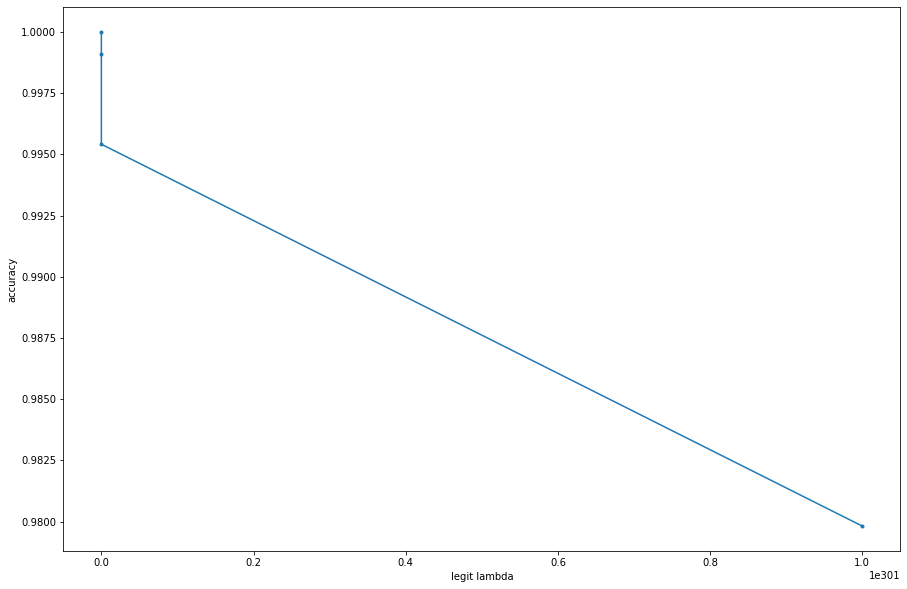

In [40]:
plt.figure(figsize=(15, 10))
plt.plot(legit_lambdas, accuracys, linestyle='-', marker='.')
plt.xlabel('legit lambda')
plt.ylabel('accuracy')
plt.show()